# CubiCasa / FloorplantoBlenderlib

In [2]:
!git clone https://github.com/rbg-research/Floor-Plan-Detection

Cloning into 'Floor-Plan-Detection'...
remote: Enumerating objects: 71, done.
remote: Total 71 (delta 0), reused 0 (delta 0), pack-reused 71 (from 1)
Receiving objects: 100% (71/71), 161.12 MiB | 26.96 MiB/s, done.
Resolving deltas: 100% (4/4), done.
Updating files: 100% (55/55), done.


In [17]:
cd Floor-Plan-Detection


[Errno 2] No such file or directory: 'Floor-Plan-Detection'
/content/Floor-Plan-Detection


In [18]:
import os

#downloading weights

!gdown 'https://drive.google.com/uc?id=1gRB7ez1e4H7a9Y09lLqRuna0luZO5VRK'

#downloading blender

blender_url =  "https://ftp.nluug.nl/pub/graphics/blender/release/Blender2.93/blender-2.93.1-linux-x64.tar.xz"
base_url = os.path.basename(blender_url)
!mkdir $blender_version
!wget -nc $blender_url
!tar -xkf $base_url -C ./$blender_version --strip-components=1
!rm blender-2.93.1-linux-x64.tar.xz

Downloading...
From (original): https://drive.google.com/uc?id=1gRB7ez1e4H7a9Y09lLqRuna0luZO5VRK
From (redirected): https://drive.google.com/uc?id=1gRB7ez1e4H7a9Y09lLqRuna0luZO5VRK&confirm=t&uuid=5cea2f64-90b3-40d0-b1b8-efddb55b4824
To: /content/Floor-Plan-Detection/model_best_val_loss_var.pkl
100% 209M/209M [00:01<00:00, 121MB/s]
mkdir: missing operand
Try 'mkdir --help' for more information.
--2025-01-23 12:29:09--  https://ftp.nluug.nl/pub/graphics/blender/release/Blender2.93/blender-2.93.1-linux-x64.tar.xz
Resolving ftp.nluug.nl (ftp.nluug.nl)... 145.220.21.40, 2001:67c:6ec:221:145:220:21:40
Connecting to ftp.nluug.nl (ftp.nluug.nl)|145.220.21.40|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 166685444 (159M) [application/octet-stream]
Saving to: ‘blender-2.93.1-linux-x64.tar.xz’

blender-2.93.1-linu 100%[===================>] 158.96M  25.8MB/s    in 7.0s    

2025-01-23 12:29:17 (22.7 MB/s) - ‘blender-2.93.1-linux-x64.tar.xz’ saved [166685444/166685444]


In [19]:
!pip install opencv-python
!pip install pyfiglet
!pip install lmdb
!pip install scikit-image
!pip install svgpathtools
!pip install shapely

In [20]:
# Add outer folder
 # Adds higher directory to python modules path.

# Import library
from utils.FloorplanToBlenderLib import *

# Other necessary libraries
import numpy as np

## Input Image
Now we need an example image to work with.

Input image: ![input](https://github.com/rbg-research/Floor-Plan-Detection/blob/main/Images/tv.jpeg?raw=1)

# Detect Contours (Object Filter)

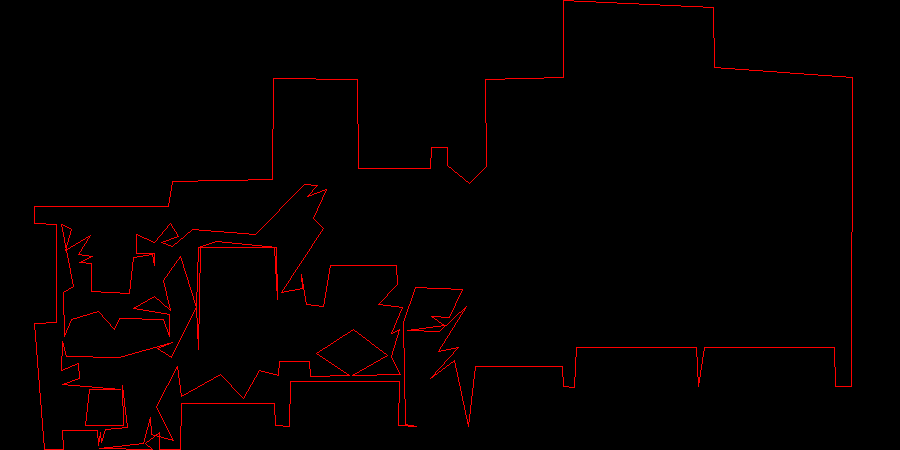

In [21]:

# Import library
from utils.FloorplanToBlenderLib import *

import cv2 # for image gathering
import numpy as np

# for visualize
from PIL import Image
from IPython.display import display

img_path = "Images/tv.jpeg"

# Read floorplan image
img = cv2.imread(img_path)

# Create blank image
height, width, channels = img.shape
blank_image = np.zeros((height,width,3), np.uint8)

# Grayscale image
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

# detect outer Contours (simple floor or roof solution), paint them red on blank_image
contour, img = detect.detectOuterContours(gray, blank_image, color=(255,0,0))

# Display
display(Image.fromarray(img))

# Detect Rooms (Object Filter)

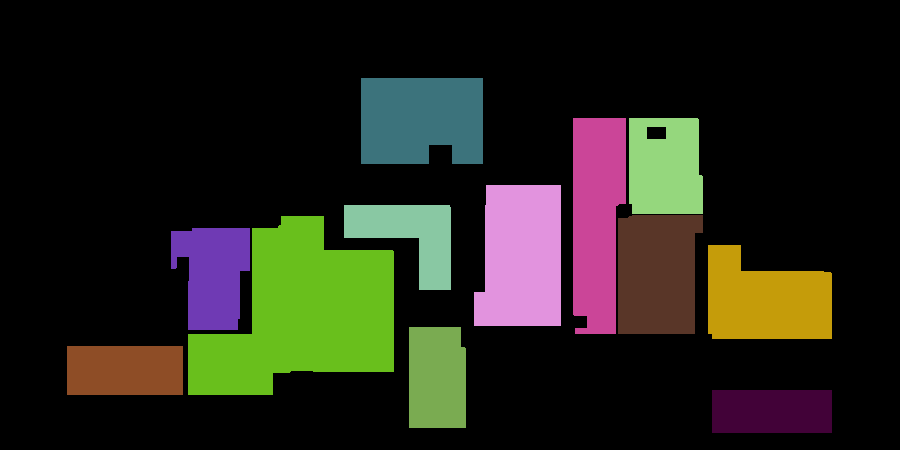

In [22]:
img = cv2.imread(img_path)

    # grayscale image
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

# create verts (points 3d), points to use in mesh creations
verts = []
# create faces for each plane, describe order to create mesh points
faces = []

# Height of waLL
height = 0.999

# Scale pixel value to 3d pos
scale = 100

gray = detect.wall_filter(gray)

gray = ~gray

rooms, colored_rooms = detect.find_rooms(gray.copy())

gray_rooms =  cv2.cvtColor(colored_rooms,cv2.COLOR_BGR2GRAY)

# get box positions for rooms
boxes, gray_rooms = detect.detectPreciseBoxes(gray_rooms, gray_rooms)
display(Image.fromarray(colored_rooms))

 #Create verts
room_count = 0
for box in boxes:
    verts.extend([transform.scale_point_to_vector(box, scale, height)])
    room_count+= 1

# create faces
for room in verts:
    count = 0
    temp = ()
    for pos in room:
        temp = temp + (count,)
        count += 1
    faces.append([(temp)])

# Detect Walls (Object Filter)

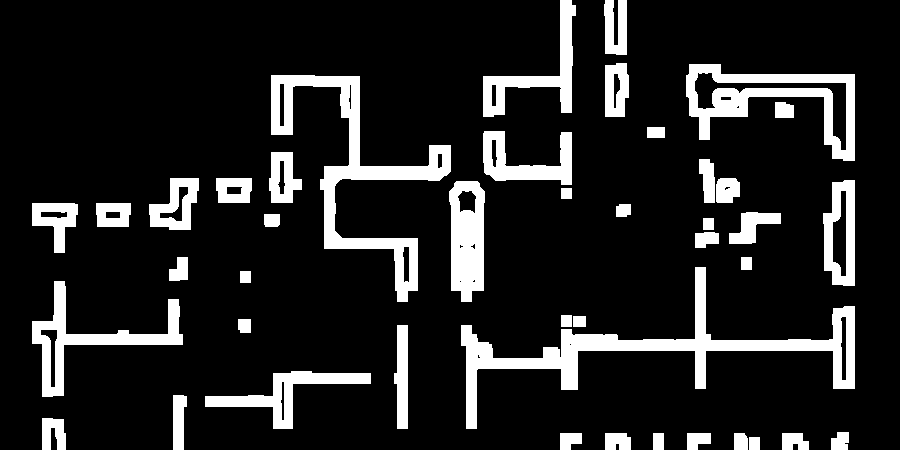

In [23]:
'''
    Generate wall data file for floorplan
    @Param img_path, path to input file
    @Param info, boolean if data should be printed
    @Return shape
    '''
from utils.FloorplanToBlenderLib import *
# Read floorplan image
img = cv2.imread(img_path)

# grayscale image
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

# create wall image (filter out small objects from image)
wall_img = detect.wall_filter(gray)

# detect walls
boxes, img = detect.detectPreciseBoxes(wall_img)

display(Image.fromarray(wall_img))

# create verts (points 3d), points to use in mesh creations
verts = []
# create faces for each plane, describe order to create mesh points
faces = []

# Height of waLL
wall_height = 1

# Scale pixel value to 3d pos
scale = 100

# Convert boxes to verts and faces
verts, faces, wall_amount = transform.create_nx4_verts_and_faces(boxes, wall_height, scale)

# Create top walls verts
verts = []
for box in boxes:
    verts.extend([transform.scale_point_to_vector(box, scale, 0)])

# create faces
faces = []
for room in verts:
    count = 0
    temp = ()
    for _ in room:
        temp = temp + (count,)
        count += 1
    faces.append([(temp)])

# CubiCasa Pre-Trained Object/Room Segmentation          
# (Deep Neural Network)

In [29]:
import sys
sys.path.append("..") # Adds higher directory to python modules path.

# Import library
from utils.FloorplanToBlenderLib import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import torch.nn.functional as F
import cv2
from torch.utils.data import DataLoader

from model import get_model
from utils.loaders import FloorplanSVG, DictToTensor, Compose, RotateNTurns
from utils.plotting import segmentation_plot, polygons_to_image, draw_junction_from_dict,           discrete_cmap
discrete_cmap()
from utils.post_prosessing import split_prediction, get_polygons, split_validation
from mpl_toolkits.axes_grid1 import AxesGrid

rot = RotateNTurns()
room_classes = ["Background", "Outdoor", "Wall", "Kitchen", "Living Room" ,"Bed Room", "Bath",
                "Entry", "Railing", "Storage", "Garage", "Undefined"]
icon_classes = ["No Icon", "Window", "Door", "Closet", "Electrical Applience" ,"Toilet", "Sink",
                "Sauna Bench", "Fire Place", "Bathtub", "Chimney"]

model = get_model('hg_furukawa_original', 51)
n_classes = 44
split = [21, 12, 11]
model.conv4_ = torch.nn.Conv2d(256, n_classes, bias=True, kernel_size=1)
model.upsample = torch.nn.ConvTranspose2d(n_classes, n_classes, kernel_size=4, stride=4)
checkpoint = torch.load('model_best_val_loss_var.pkl')

model.load_state_dict(checkpoint['model_state'])
model.eval()
model.cuda()

# Create tensor for pytorch
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # correct color channels

# Image transformation to range (-1,1)
img = 2 * (img / 255.0) - 1

# Move from (h,w,3)--->(3,h,w) as model input dimension is defined like this
img = np.moveaxis(img, -1, 0)

# Convert to pytorch, enable cuda
img = torch.tensor([img.astype(np.float32)]).cuda()
n_rooms = 12
n_icons = 11

with torch.no_grad():
    #Check if shape of image is odd or even
    size_check = np.array([img.shape[2],img.shape[3]])%2

    height = img.shape[2] - size_check[0]
    width = img.shape[3] - size_check[1]

    img_size = (height, width)

    rotations = [(0, 0), (1, -1), (2, 2), (-1, 1)]
    pred_count = len(rotations)
    prediction = torch.zeros([pred_count, n_classes, height, width])
    for i, r in enumerate(rotations):
        forward, back = r
        # We rotate first the image
        rot_image = rot(img, 'tensor', forward)
        pred = model(rot_image)
        # We rotate prediction back
        pred = rot(pred, 'tensor', back)
        # We fix heatmaps
        pred = rot(pred, 'points', back)
        # We make sure the size is correct
        pred = F.interpolate(pred, size=(height, width), mode='bilinear', align_corners=True)
        # We add the prediction to output
        prediction[i] = pred[0]

prediction = torch.mean(prediction, 0, True)


rooms_pred = F.softmax(prediction[0, 21:21+12], 0).cpu().data.numpy()
rooms_pred = np.argmax(rooms_pred, axis=0)

icons_pred = F.softmax(prediction[0, 21+12:], 0).cpu().data.numpy()
icons_pred = np.argmax(icons_pred, axis=0)

heatmaps, rooms, icons = split_prediction(prediction, img_size, split)
polygons, types, room_polygons, room_types = get_polygons((heatmaps, rooms, icons), 0.2, [1, 2])

wall_polygon_numbers=[i for i,j in enumerate(types) if j['type']=='wall']
boxes=[]
for i,j in enumerate(polygons):
    if i in wall_polygon_numbers:
        temp=[]
        for k in j:
            temp.append(np.array([k]))
        boxes.append(np.array(temp))

verts, faces, wall_amount = transform.create_nx4_verts_and_faces(boxes, wall_height, scale)

# Create top walls verts
verts = []
for box in boxes:
    verts.extend([transform.scale_point_to_vector(box, scale, 0)])

# create faces
faces = []
for room in verts:
    count = 0
    temp = ()
    for _ in room:
        temp = temp + (count,)
        count += 1
    faces.append([(temp)])


AttributeError: module 'matplotlib.cm' has no attribute 'register_cmap'

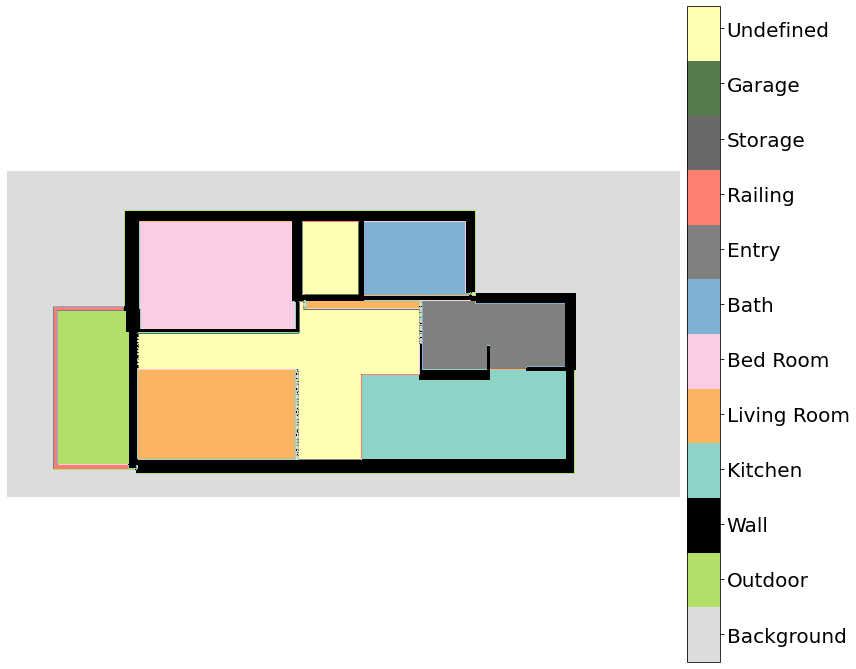

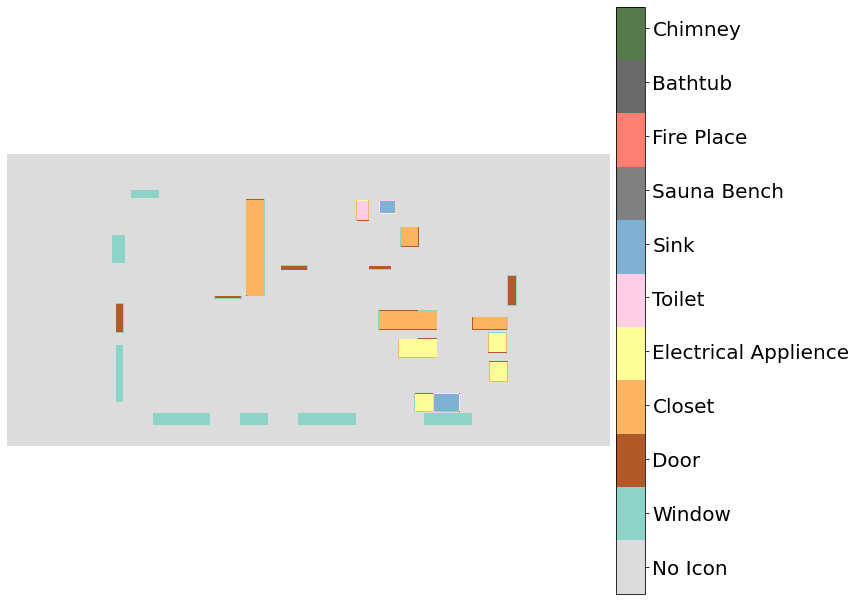

In [ ]:
pol_room_seg, pol_icon_seg = polygons_to_image(polygons, types, room_polygons, room_types, height, width)


plt.figure(figsize=(12,12))
ax = plt.subplot(1, 1, 1)
ax.axis('off')
rseg = ax.imshow(pol_room_seg, cmap='rooms', vmin=0, vmax=n_rooms-0.1)
cbar = plt.colorbar(rseg, ticks=np.arange(n_rooms) + 0.5, fraction=0.046, pad=0.01)
cbar.ax.set_yticklabels(room_classes, fontsize=20)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,12))
ax = plt.subplot(1, 1, 1)
ax.axis('off')
iseg = ax.imshow(pol_icon_seg, cmap='icons', vmin=0, vmax=n_icons-0.1)
cbar = plt.colorbar(iseg, ticks=np.arange(n_icons) + 0.5, fraction=0.046, pad=0.01)
cbar.ax.set_yticklabels(icon_classes, fontsize=20)
plt.tight_layout()
plt.show()

# Generate data files and Blender files (Using CubiCasa and Super-Resolution)

In [ ]:

import FloorplanToSTL as stl
import config

# can specify or use default paths in config files
stl.createFloorPlan(image_path = config.image_path, target_path = config.target_path, SR_Check=True)

# Note: USE SR_Check = False for Original Image

/home/ubuntu/2Dto3D/GIT/ftb_CubiCasa_v4/floortrans/plotting.py:591: UserWarning: Trying to register the cmap 'rooms' which already exists.
  cm.register_cmap(cmap=cmap3)
/home/ubuntu/2Dto3D/GIT/ftb_CubiCasa_v4/floortrans/plotting.py:597: UserWarning: Trying to register the cmap 'icons' which already exists.
  cm.register_cmap(cmap=cmap3)
/home/ubuntu/2Dto3D/GIT/ftb_CubiCasa_v4/floortrans/plotting.py:605: UserWarning: Trying to register the cmap 'rooms_furu' which already exists.
  cm.register_cmap(cmap=cmap3)
/home/ubuntu/2Dto3D/GIT/ftb_CubiCasa_v4/floortrans/plotting.py:611: UserWarning: Trying to register the cmap 'rooms_furu' which already exists.
  cm.register_cmap(cmap=cmap3)


 ----- Generate  Images/example.png  at pos  None  rot  None  -----
Approximated apartment size :  1731843.0
Created file : Data/2/floor_verts.txt
Created file : Data/2/floor_faces.txt
Walls created :  172
Created file : Data/2/wall_verts.txt
Created file : Data/2/wall_faces.txt
Created file : Data/2/top_wall_verts.txt
Created file : Data/2/top_wall_faces.txt
Number of rooms detected :  22
Created file : Data/2/rooms_verts.txt
Created file : Data/2/rooms_faces.txt
Created file : Data/2/transform.txt
